## Trabalho 2 de Aprendizado de Máquina
Alunos: 
* Martin Heckmann (758986)
* João Augusto Leite (743551) 

In [ ]:
!pip install transformers emoji --quiet

     |████████████████████████████████| 2.1MB 17.6MB/s 
     |████████████████████████████████| 133kB 55.7MB/s 
     |████████████████████████████████| 3.3MB 53.5MB/s 
     |████████████████████████████████| 901kB 54.0MB/s 


In [ ]:
!wget https://sites.google.com/site/offensevalsharedtask/olid/OLIDv1.0.zip?attredirects=0&d=1
!unzip OLIDv1.0.zip\?attredirects\=0

--2021-04-19 18:17:41--  https://sites.google.com/site/offensevalsharedtask/olid/OLIDv1.0.zip?attredirects=0
Resolving sites.google.com (sites.google.com)... 172.217.15.78, 2607:f8b0:4004:810::200e
Connecting to sites.google.com (sites.google.com)|172.217.15.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://ef80a887-a-62cb3a1a-s-sites.googlegroups.com/site/offensevalsharedtask/olid/OLIDv1.0.zip?attachauth=ANoY7crPhbU1exG3c1s10095ZtxgvWmEZVXqlOWnyJJaRgwy6VjEr6ucm-QbIdhuF4AL9nCHj5iYAM_4b8EYFAABXwOZDHx8JyVF7U6zKh0RlZeljZmYau_3D-UhuTALIYUssoJPD0javoiP0B6iK2i1-gtoZTsIxwveBq3fWXAGy7HeGX0_pPkoinoNRG25Msyhebo8rXUjW6XE6zxlU6AowyuklqbPHB68RHAXLJCdkK8PYIawnpU%3D&attredirects=0 [following]
--2021-04-19 18:17:41--  https://ef80a887-a-62cb3a1a-s-sites.googlegroups.com/site/offensevalsharedtask/olid/OLIDv1.0.zip?attachauth=ANoY7crPhbU1exG3c1s10095ZtxgvWmEZVXqlOWnyJJaRgwy6VjEr6ucm-QbIdhuF4AL9nCHj5iYAM_4b8EYFAABXwOZDHx8JyVF7U6zKh0RlZeljZmYau_3D-UhuTAL

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from wordcloud import WordCloud
from nltk import FreqDist, word_tokenize, download
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import copy
import time
import emoji

In [ ]:
download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class Config:
    train_size=0.7

    # bert
    model_name="bert-base-uncased" # https://huggingface.co/models
    do_lower_case=True
    max_length=80
    batch_size=16
    learning_rate=5e-5
    random_seed=42

    # svm
    svm_params = {'kernel': ('linear', 'rbf'), 'C':[1, 3, 5, 10, 15]}

In [ ]:
# read data
df = pd.read_csv("olid-training-v1.0.tsv", sep="\t")
df["subtask_a"] = df["subtask_a"].apply(lambda x: 1 if x == "OFF" else 0)

# convert emojis to text
df["tweet"] = df["tweet"].apply(emoji.demojize)

# split into train val test
train_df, aux_df = train_test_split(df, train_size=Config.train_size, random_state=Config.random_seed)
val_df, test_df = train_test_split(aux_df, train_size=0.5, random_state=Config.random_seed)

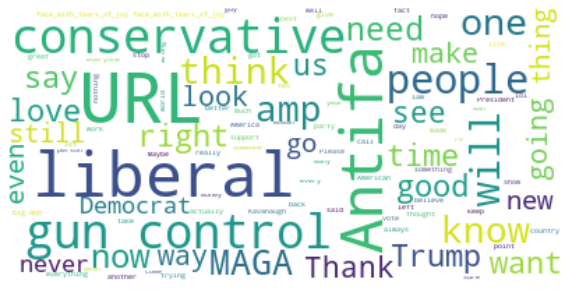

In [ ]:
non_toxic = df[df["subtask_a"] == 0]["tweet"]
word_count = {}
non_toxic = " ".join(non_toxic.to_list()).replace("USER", "")
for word in non_toxic.split:
  if word not in word_count:
    word_count[word] = 1
  else:
    word_count[word] += 1

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(non_toxic.to_list()).replace("USER", ""))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

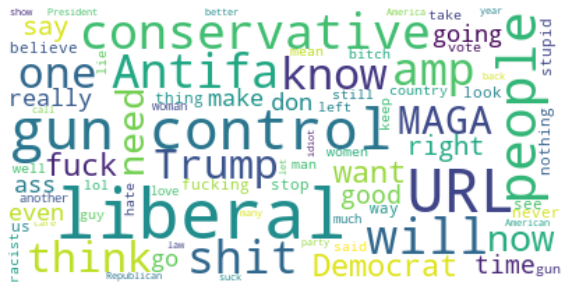

In [ ]:
toxic = df[df["subtask_a"] == 1]["tweet"]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(toxic.to_list()).replace("USER", ""))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# SVM

In [ ]:
bow = CountVectorizer()
X_train = bow.fit_transform(train_df["tweet"])
y_train = train_df["subtask_a"]
X_test = bow.transform(test_df["tweet"])
y_test = test_df["subtask_a"]

svm = SVC()
gs = GridSearchCV(svm, Config.svm_params)
gs.fit(X_train, y_train)

preds = gs.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1309
           1       0.73      0.44      0.55       677

    accuracy                           0.75      1986
   macro avg       0.75      0.68      0.69      1986
weighted avg       0.75      0.75      0.74      1986



In [ ]:
gs.best_estimator_

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# BERT

In [ ]:
class OLIDDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        encoded = tokenizer(
            self.df.loc[idx,"tweet"],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=Config.max_length
        )
        label = torch.LongTensor([self.df.loc[idx, "subtask_a"]]).squeeze()
        encoded["input_ids"] = encoded["input_ids"][0]
        encoded["label"] = label

        return encoded


In [ ]:
def train_model(model, dataloaders, optimizer, device, num_epochs=5):
    model.to(device)

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_i, sample_batch in enumerate(dataloaders[phase]):
                input_ids = sample_batch["input_ids"].to(device)
                attention_mask = sample_batch["attention_mask"].to(device)
                label = sample_batch["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=label)
                    _, preds = torch.max(outputs.logits, axis=1)
                    loss = outputs[0]

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == label)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print(f"new best model! acc: {epoch_acc}")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained(
    Config.model_name,
    do_lower_case=Config.do_lower_case,
)

# create dataset object
train = OLIDDataset(train_df.reset_index(drop=True), tokenizer)
val = OLIDDataset(val_df.reset_index(drop=True), tokenizer)
test = OLIDDataset(test_df.reset_index(drop=True), tokenizer)

# construct dataloader
dataloaders = {
    "train": DataLoader(train, batch_size=Config.batch_size, num_workers=2, shuffle=True),
    "val": DataLoader(val, batch_size=Config.batch_size, num_workers=2, shuffle=True),
    "test": DataLoader(test, batch_size=Config.batch_size, num_workers=2, shuffle=True)
}

In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(Config.model_name, num_labels=2)
optimizer = AdamW(bert_model.parameters(), lr=Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
bert_model = train_model(bert_model, dataloaders, optimizer, device, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4857 Acc: 0.7749
val Loss: 0.4711 Acc: 0.7905
new best model! acc: 0.7905337361530715

Epoch 1/4
----------
train Loss: 0.3625 Acc: 0.8464
val Loss: 0.4770 Acc: 0.8031
new best model! acc: 0.8031218529707955

Epoch 2/4
----------
train Loss: 0.2440 Acc: 0.9097
val Loss: 0.5729 Acc: 0.7694

Epoch 3/4
----------
train Loss: 0.1442 Acc: 0.9517
val Loss: 0.7638 Acc: 0.7810

Epoch 4/4
----------
train Loss: 0.0974 Acc: 0.9692
val Loss: 0.8607 Acc: 0.7800

Training complete in 12m 55s
Best val Acc: 0.803122


In [ ]:
def evaluate(bert_model, dataloaders, device):
    bert_model.to(device)
    bert_model.eval()

    results = {"pred": [], "true": []}
    for batch_i, sample_batch in enumerate(dataloaders["test"]):
        input_ids = sample_batch["input_ids"].to(device)
        attention_mask = sample_batch["attention_mask"].to(device)
        label = sample_batch["label"].to(device)

        output = bert_model(input_ids, labels=label, attention_mask=attention_mask)
        _, preds = torch.max(output.logits, axis=1)

        results["pred"] += preds.tolist()
        results["true"] += label.tolist()

    return results

In [ ]:
results = evaluate(bert_model, dataloaders, device)

In [ ]:
print(classification_report(results["true"], results["pred"]))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1309
           1       0.77      0.58      0.66       677

    accuracy                           0.80      1986
   macro avg       0.79      0.75      0.76      1986
weighted avg       0.80      0.80      0.79      1986

